In [ ]:
!pip install pyts
# https://chat.openai.com/c/7a3cac1f-f16c-4f15-93c2-dea9ff5005f9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.1 MB/s eta 0:00:00


In [ ]:
# Imports
import io
import os
import pyts
import math
import openpyxl
import numpy as np
import pandas as pd
from tensorflow import keras
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import Sequential
from contextlib import redirect_stdout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField, RecurrencePlot
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Initial data preparation

0
count    2449.000000
mean       27.460673
std         4.249785
min        15.900000
25%        24.800000
50%        26.833333
75%        29.700000
max        39.900000
Name: B.RTD1, dtype: float64


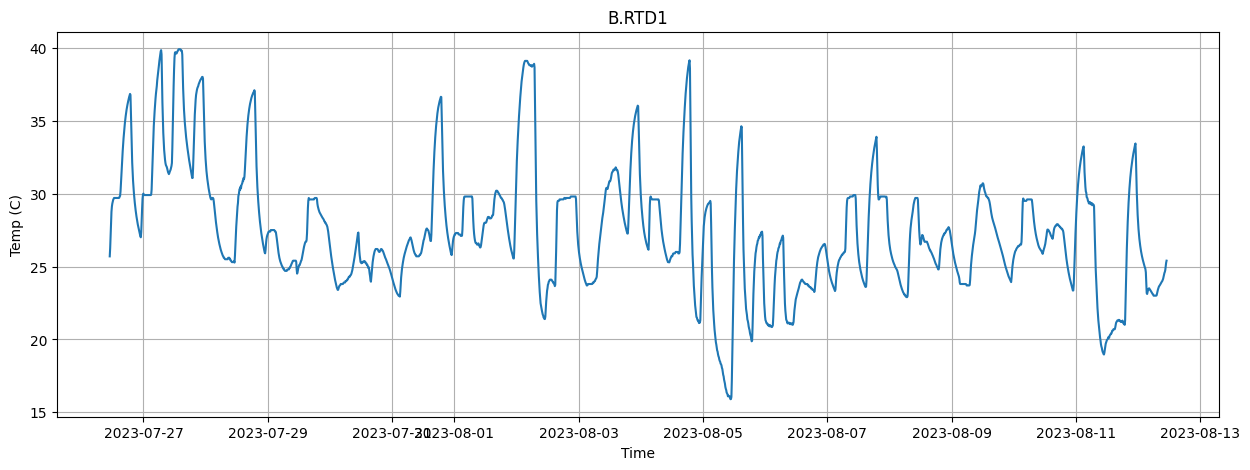

In [ ]:
# 1.1 Load the Data:
df = pd.read_hdf('/content/drive/My Drive/TSF_GAF_CNN/src/RICO1_Dataset.hdf', key='all')
df['_time'] = pd.to_datetime(df['_time'])
df.set_index('_time', inplace=True)
df = df.resample('10T').mean()
# df = df['B.RTD1'] #2449 rows

# 1.2 Inspect the Data: Check for the presence of missing values, anomalies, or outliers.
print(df['B.RTD1'].isnull().sum())
print(df['B.RTD1'].describe())

# 1.3 Visualise raw data
plt.figure(figsize=(15, 5))
plt.plot(df['B.RTD1'])
plt.ylabel('Temp (C)')
plt.xlabel('Time')
plt.title('B.RTD1')
plt.grid(True)
plt.show()

# 2. Data transformation

Train data size: (1959, 1) , Test data size: (490, 1)
Normalising train data... 
Normalising test data... 
Standarising train data... 
Standarising test data... 


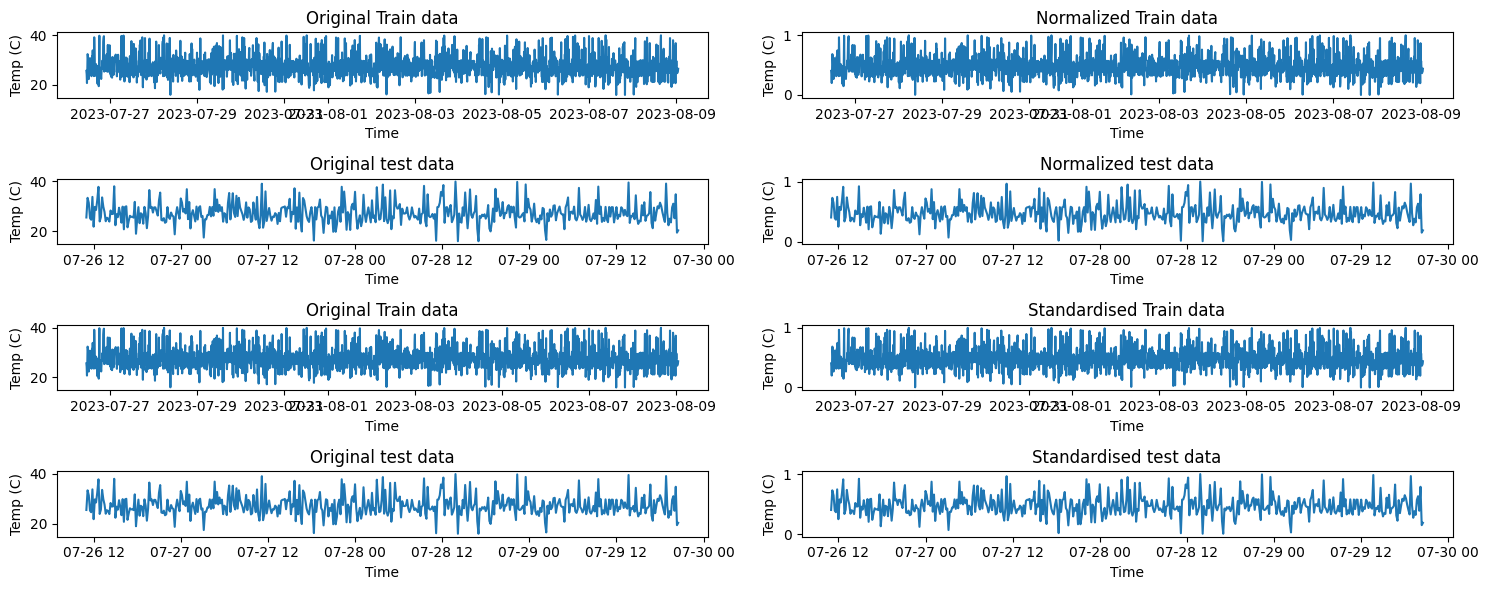

(12, 200, 1) (12, 36, 1)
(2, 200, 1) (2, 36, 1)
(12, 200, 1) (12, 36, 1)
(2, 200, 1) (2, 36, 1)


In [ ]:
## 2.1 Split into train and test ###########################################################################
data = df['B.RTD1'].values.reshape(-1, 1)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
print(f'Train data size: {train_data.shape} , Test data size: {test_data.shape}')


## 2.2 Normalise and standarise data ###########################################################################
# Normalising
scaler = MinMaxScaler()

print('Normalising train data... ')
train_norm = scaler.fit_transform(train_data)

print('Normalising test data... ')
test_norm = scaler.transform(test_data)


# Standardising
std_scaler = StandardScaler()
print('Standarising train data... ')
train_std = std_scaler.fit_transform(train_data)

print('Standarising test data... ')
test_std = std_scaler.transform(test_data)


# Plotting
fig, axs = plt.subplots(4, 2, figsize=(15,6))
axs[0,0].plot(df.index[:len(train_data)], train_data)
axs[0,0].set_title('Original Train data')
axs[0,0].set_ylabel('Temp (C)')
axs[0,0].set_xlabel('Time')
axs[0,1].plot(df.index[:len(train_norm)], train_norm)
axs[0,1].set_title('Normalized Train data')
axs[0,1].set_ylabel('Temp (C)')
axs[0,1].set_xlabel('Time')

axs[1,0].plot(df.index[:len(test_data)], test_data)
axs[1,0].set_title('Original test data')
axs[1,0].set_ylabel('Temp (C)')
axs[1,0].set_xlabel('Time')
axs[1,1].plot(df.index[:len(test_norm)], test_norm)
axs[1,1].set_title('Normalized test data')
axs[1,1].set_ylabel('Temp (C)')
axs[1,1].set_xlabel('Time')

axs[2,0].plot(df.index[:len(train_data)], train_data)
axs[2,0].set_title('Original Train data')
axs[2,0].set_ylabel('Temp (C)')
axs[2,0].set_xlabel('Time')
axs[2,1].plot(df.index[:len(train_norm)], train_norm)
axs[2,1].set_title('Standardised Train data')
axs[2,1].set_ylabel('Temp (C)')
axs[2,1].set_xlabel('Time')

axs[3,0].plot(df.index[:len(test_data)], test_data)
axs[3,0].set_title('Original test data')
axs[3,0].set_ylabel('Temp (C)')
axs[3,0].set_xlabel('Time')
axs[3,1].plot(df.index[:len(test_norm)], test_norm)
axs[3,1].set_title('Standardised test data')
axs[3,1].set_ylabel('Temp (C)')
axs[3,1].set_xlabel('Time')
plt.tight_layout()
plt.show()


## 2.3 Create sequences ###########################################################################
sequence_length = 200  # Length of each input sequence
forecast_horizon = 36  # Forecasting 36 values into the future
overlap = 50  # Overlap between input sequences

def create_seq(data, seq_len, forecast, overlap):
  input_sequences = []
  output_sequences = []

  for i in range(0, len(data) - seq_len - forecast, seq_len - overlap):
      input_seq = data[i:i+seq_len]
      output_seq =  data[i+seq_len:i+seq_len+forecast]
      input_sequences.append(input_seq)
      output_sequences.append(output_seq)
  return input_sequences, output_sequences

# Normalised
train_seq_norm, train_norm_labels = create_seq(train_norm, sequence_length, forecast_horizon, overlap)
test_seq_norm,test_norm_labels = create_seq(test_norm, sequence_length, forecast_horizon, overlap)
print(np.array(train_seq_norm).shape, np.array(train_norm_labels).shape)
print(np.array(test_seq_norm).shape, np.array(test_norm_labels).shape)

# Standardised
train_seq_std, train_std_labels = create_seq(train_std, sequence_length, forecast_horizon, overlap)
test_seq_std, test_std_labels = create_seq(test_std, sequence_length, forecast_horizon, overlap)
print(np.array(train_seq_std).shape, np.array(train_std_labels).shape)
print(np.array(test_seq_std).shape, np.array(test_std_labels).shape)


## 2.3 GAF and RP image translation



## 2.4 Concatenate all images


## 2.5 Split into train and split again



# 3. Transforming data into images

## 3.1 GAF methods

(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)
(12, 44, 44) (2, 44, 44)


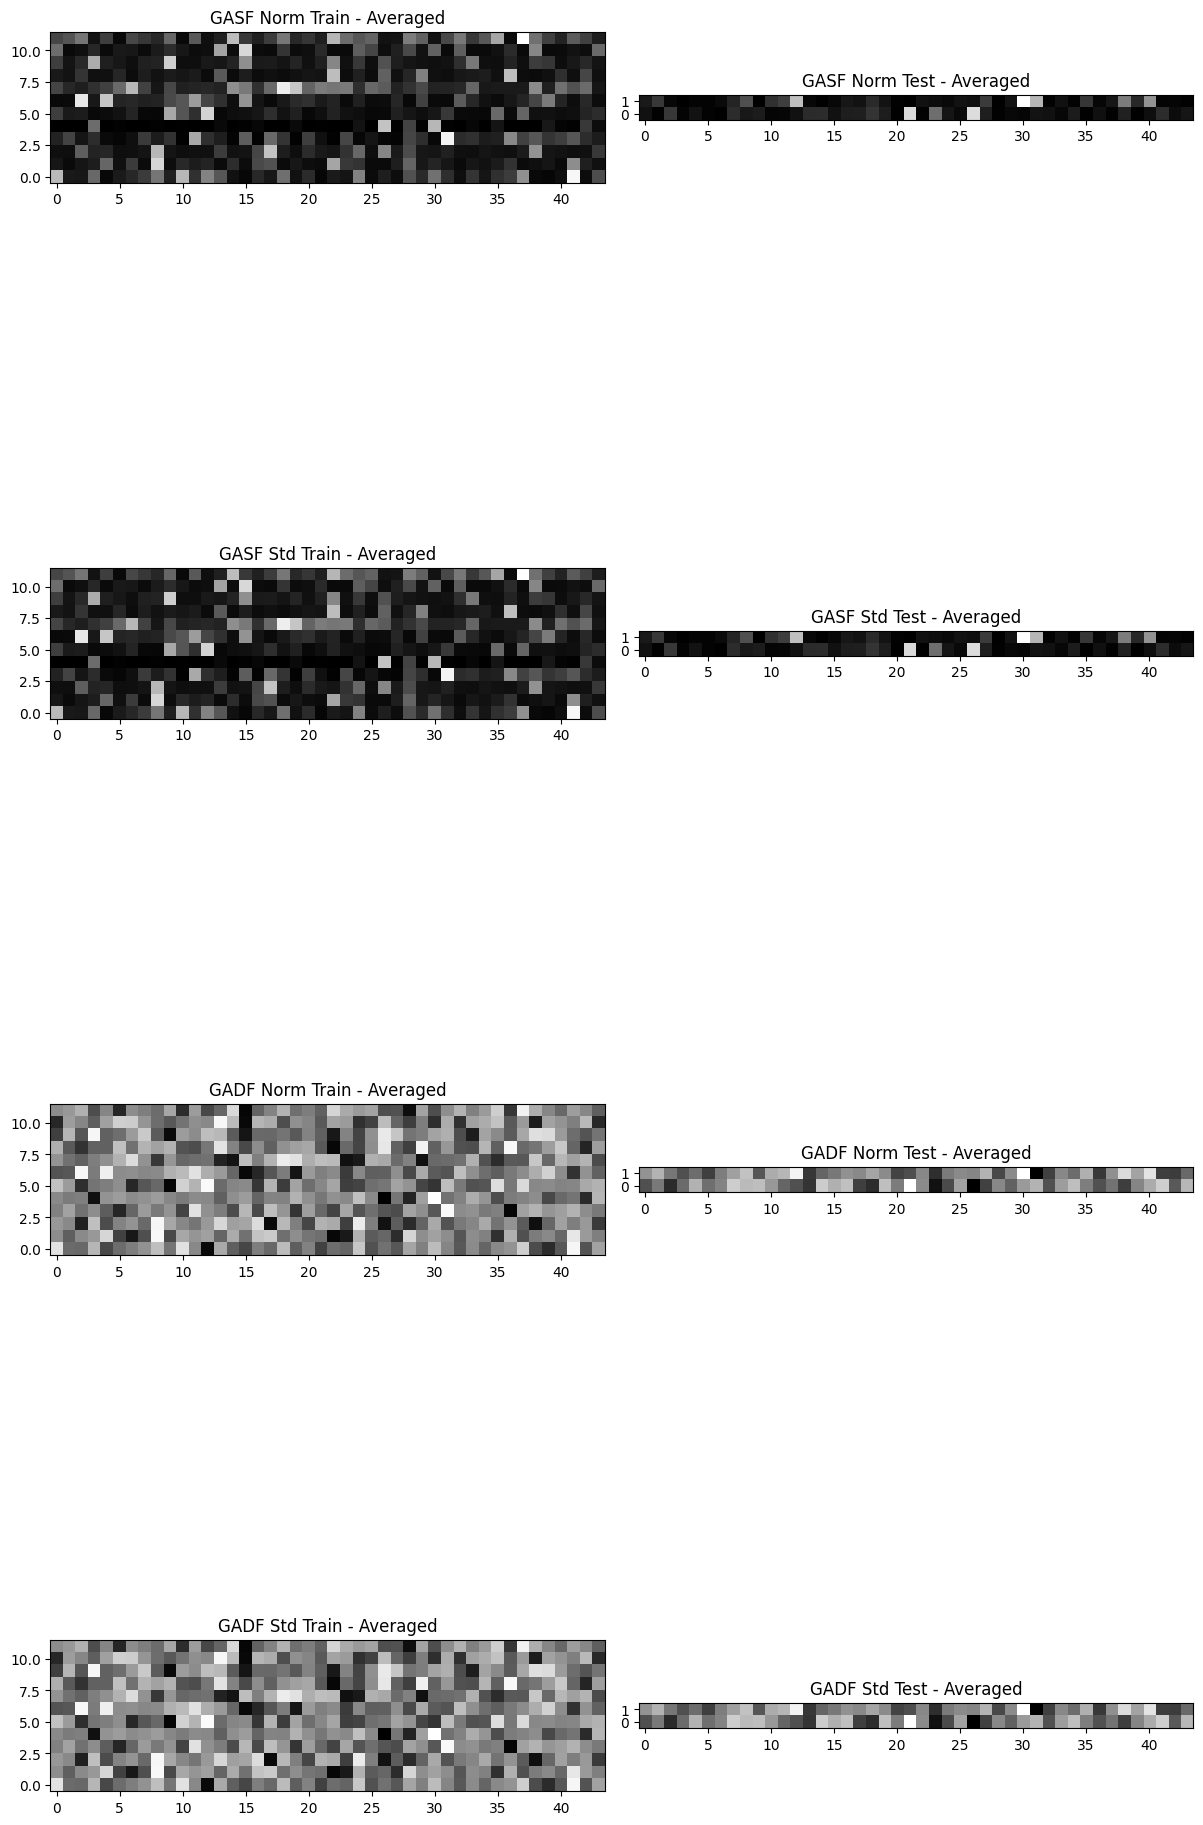

In [ ]:
image_size = int(math.sqrt(len(train_data))) # sqrt OR nearest lower divisor of the time series length after splitting

## 3.1 Definition
# Summation
gasf = GramianAngularField(image_size=image_size, method='summation')
# Difference
gadf = GramianAngularField(image_size=image_size, method='difference')

# Summation
gasf_train_norm = []
gasf_test_norm = []
gasf_train_std = []
gasf_test_std = []

# Difference
gadf_train_norm = []
gadf_test_norm = []
gadf_train_std = []
gadf_test_std = []

## 3.2 Transform the TRAINING data into GAF images
for seq in train_seq_norm: # Normalised
  # Summation
  gasf_norm_train = gasf.fit_transform(seq.reshape(1, -1))
  gasf_train_norm.append(gasf_norm_train[0])
  # Difference
  gadf_norm_train = gadf.fit_transform(seq.reshape(1, -1))
  gadf_train_norm.append(gadf_norm_train[0])

for seq in train_seq_std: # Standarised
  # Summation
  gasf_std_train = gasf.fit_transform(seq.reshape(1, -1))
  gasf_train_std.append(gasf_std_train[0])
  # Difference
  gadf_std_train = gadf.fit_transform(seq.reshape(1, -1))
  gadf_train_std.append(gadf_std_train[0])

## 3.3 Transform the TEST data into GAF images
for seq in test_seq_norm: # Normalised
  # Summation
  gasf_norm_test = gasf.transform(seq.reshape(1, -1))
  gasf_test_norm.append(gasf_norm_test[0])
  # Difference
  gadf_norm_test = gadf.transform(seq.reshape(1, -1))
  gadf_test_norm.append(gadf_norm_test[0])

for seq in test_seq_std: # Standardised
  # Summation
  gasf_std_test = gasf.transform(seq.reshape(1, -1))
  gasf_test_std.append(gasf_std_test[0])
  # Difference
  gadf_std_test = gadf.transform(seq.reshape(1, -1))
  gadf_test_std.append(gadf_std_test[0])

print(np.array(gasf_train_norm).shape, np.array(gasf_test_norm).shape)
print(np.array(gasf_train_std).shape,  np.array(gasf_test_std).shape)
print(np.array(gadf_train_norm).shape, np.array(gadf_test_norm).shape)
print(np.array(gadf_train_std).shape,  np.array(gadf_test_std).shape)

## 3.4 Concatenate all images NORMALISED / STANDARISED and TRAIN / TEST
# GASF
all_gasf_norm_train = np.stack(gasf_train_norm, axis=0)
all_gasf_norm_test = np.stack(gasf_test_norm, axis=0)
all_gasf_std_train = np.stack(gasf_train_std, axis=0)
all_gasf_std_test = np.stack(gasf_test_std, axis=0)
print(all_gasf_norm_train.shape, all_gasf_norm_test.shape)
print(all_gasf_std_train.shape, all_gasf_std_test.shape)

# GADF
all_gadf_norm_train = np.stack(gadf_train_norm, axis=0)
all_gadf_norm_test = np.stack(gadf_test_norm, axis=0)
all_gadf_std_train = np.stack(gadf_train_std, axis=0)
all_gadf_std_test = np.stack(gadf_test_std, axis=0)
print(all_gadf_norm_train.shape, all_gadf_norm_test.shape)
print(all_gadf_std_train.shape, all_gadf_std_test.shape)

# Plotting the full image
def plot_image(ax, data, title):
    if data.ndim == 3:  # If the data has multiple channels
        ax.imshow(np.mean(data, axis=-1), cmap='gray', origin='lower')  # Averaging over channels
    else:  # If the data is already 2D
        ax.imshow(data, cmap='gray', origin='lower')
    ax.set_title(title)

fig, axes = plt.subplots(4, 2, figsize=(12, 24))
# Plotting the averaged images for each type
# GASF
plot_image(axes[0, 0], all_gasf_norm_train, "GASF Norm Train - Averaged")
plot_image(axes[0, 1], all_gasf_norm_test, "GASF Norm Test - Averaged")
plot_image(axes[1, 0], all_gasf_std_train, "GASF Std Train - Averaged")
plot_image(axes[1, 1], all_gasf_std_test, "GASF Std Test - Averaged")
# GADF
plot_image(axes[2, 0], all_gadf_norm_train, "GADF Norm Train - Averaged")
plot_image(axes[2, 1], all_gadf_norm_test, "GADF Norm Test - Averaged")
plot_image(axes[3, 0], all_gadf_std_train, "GADF Std Train - Averaged")
plot_image(axes[3, 1], all_gadf_std_test, "GADF Std Test - Averaged")
plt.tight_layout()
plt.show()

## 3.5 Split into train and split again

## 3.2 Recurrence Plot

(12, 200, 200) (2, 200, 200)
(12, 200, 200) (2, 200, 200)
(12, 200, 200) (2, 200, 200)
(12, 200, 200) (2, 200, 200)
(12, 200, 200) (2, 200, 200)
(12, 200, 200) (12, 200, 200)
(12, 200, 200) (2, 200, 200)
(12, 200, 200) (12, 200, 200)


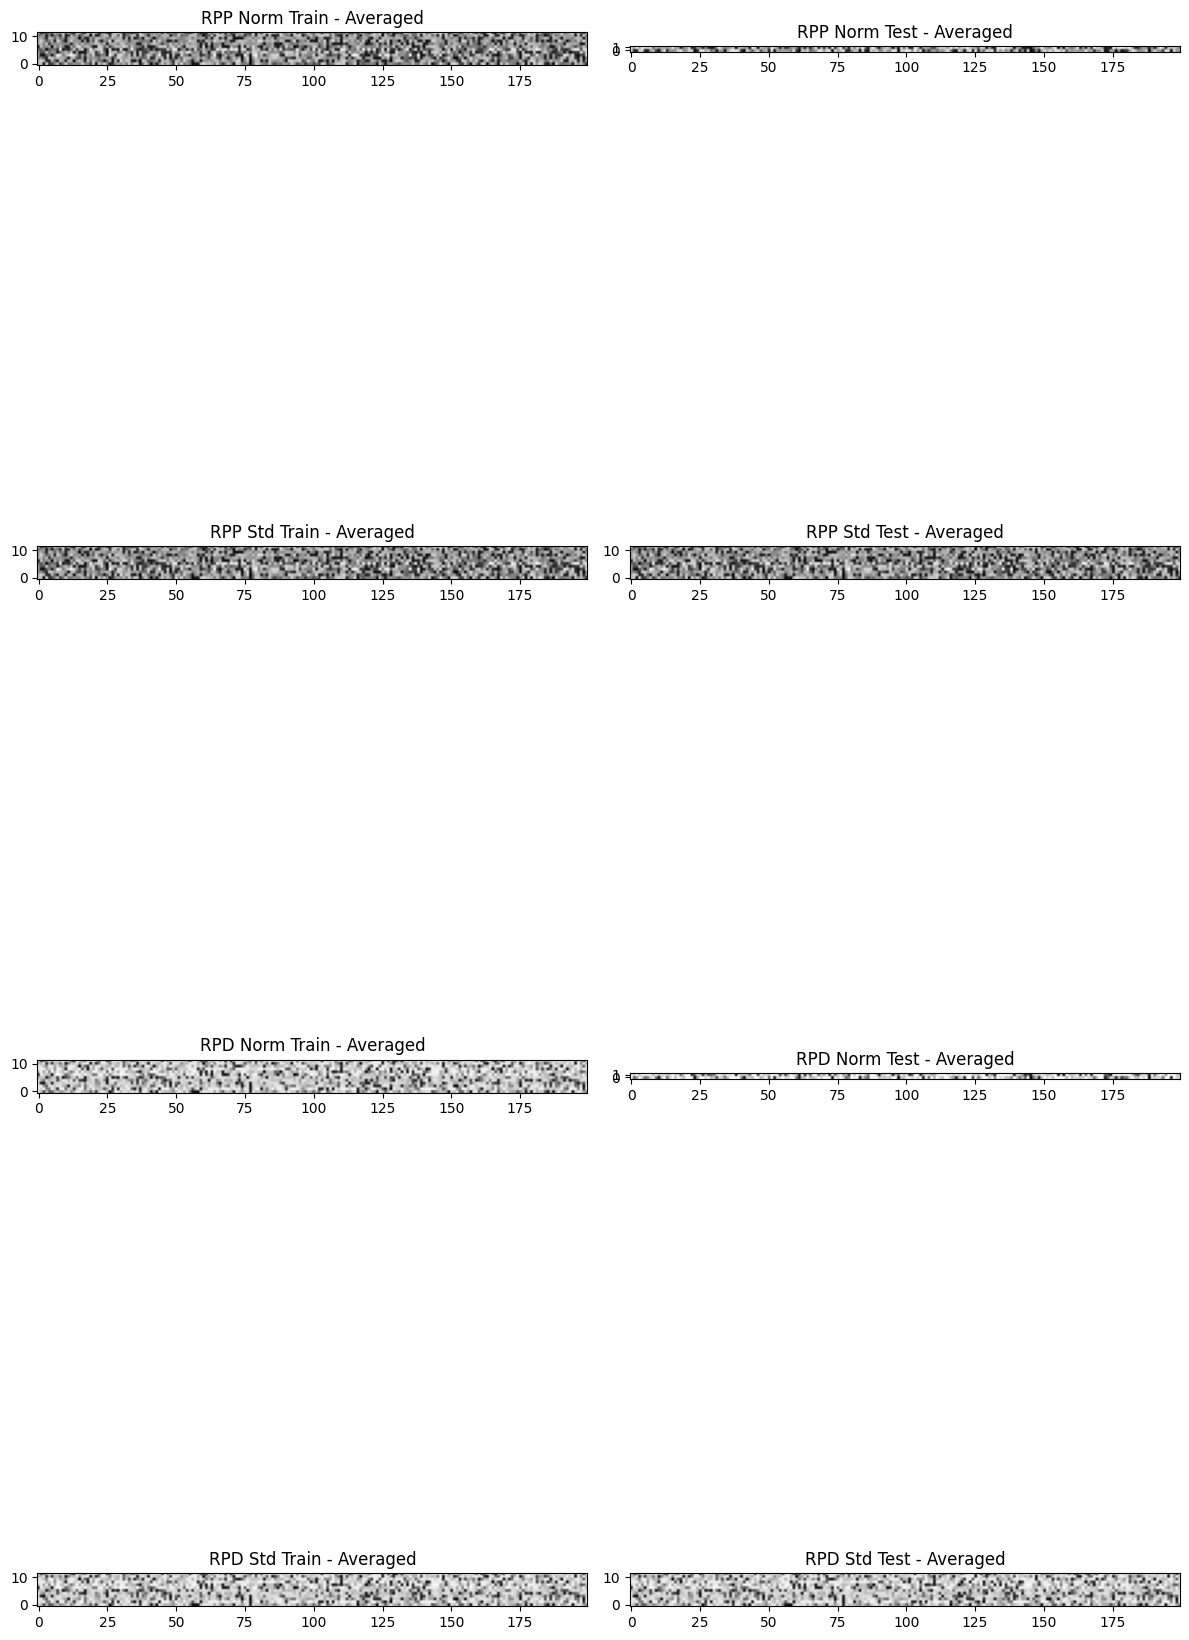

In [ ]:
# Point
rpp = RecurrencePlot(threshold='point', percentage=20)
# Distance
rpd = RecurrencePlot(threshold='distance', percentage=20)

# Point
rpp_train_norm = []
rpp_test_norm = []
rpp_train_std = []
rpp_test_std = []

# Distance
rpd_train_norm = []
rpd_test_norm = []
rpd_train_std = []
rpd_test_std = []

# Transform the TRAIN data into RP images
for seq in train_seq_norm: # Normalised
  # Point
  rpp_norm_train = rpp.fit_transform(seq.reshape(1, -1))
  rpp_train_norm.append(rpp_norm_train[0])
  # Distance
  rpd_norm_train = rpd.fit_transform(seq.reshape(1, -1))
  rpd_train_norm.append(rpd_norm_train[0])

for seq in train_seq_std: # Standardised
  # Point
  rpp_std_train = rpp.fit_transform(seq.reshape(1, -1))
  rpp_train_std.append(rpp_std_train[0])
  # Distance
  rpd_std_train = rpd.fit_transform(seq.reshape(1, -1))
  rpd_train_std.append(rpd_std_train[0])

# Transform the TEST data into RP images
for seq in test_seq_norm: # Normalised
  # Point
  rpp_norm_test = rpp.transform(seq.reshape(1, -1))
  rpp_test_norm.append(rpp_norm_test[0])
  # Difference
  rpd_norm_test = rpd.transform(seq.reshape(1, -1))
  rpd_test_norm.append(rpd_norm_test[0])

for seq in test_seq_std: # Standardised
  # Point
  rpp_std_test = rpp.transform(seq.reshape(1, -1))
  rpp_test_std.append(rpp_std_test[0])
  # Difference
  rpd_std_test = rpd.transform(seq.reshape(1, -1))
  rpd_test_std.append(rpd_std_test[0])

print(np.array(rpp_train_norm).shape, np.array(rpp_test_norm).shape)
print(np.array(rpp_train_std).shape,  np.array(rpp_test_std).shape)
print(np.array(rpd_train_norm).shape, np.array(rpd_test_norm).shape)
print(np.array(rpd_train_std).shape,  np.array(rpd_test_std).shape)


## 3.4 Concatenate all images NORMALISED / STANDARISED and TRAIN / TEST
# Point
all_rpp_norm_train = np.stack(rpp_train_norm, axis=0)
all_rpp_norm_test = np.stack(rpp_test_norm, axis=0)
all_rpp_std_train = np.stack(rpp_train_std, axis=0)
all_rpp_std_test = np.stack(rpp_train_std, axis=0)
print(all_rpp_norm_train.shape, all_rpp_norm_test.shape)
print(all_rpp_std_train.shape, all_rpp_std_test.shape)


# Distance
all_rpd_norm_train = np.stack(rpd_train_norm, axis=0)
all_rpd_norm_test = np.stack(rpd_test_norm, axis=0)
all_rpd_std_train = np.stack(rpd_train_std, axis=0)
all_rpd_std_test = np.stack(rpd_train_std, axis=0)
print(all_rpd_norm_train.shape, all_rpd_norm_test.shape)
print(all_rpd_std_train.shape, all_rpd_std_test.shape)


# Plotting the full image
# Plotting the full image
def plot_image(ax, data, title):
    if data.ndim == 3:  # If the data has multiple channels
        ax.imshow(np.mean(data, axis=-1), cmap='gray', origin='lower')  # Averaging over channels
    else:  # If the data is already 2D
        ax.imshow(data, cmap='gray', origin='lower')
    ax.set_title(title)

fig, axes = plt.subplots(4, 2, figsize=(12, 24))
# Plotting the averaged images for each type
# Point
plot_image(axes[0, 0], all_rpp_norm_train, "RPP Norm Train - Averaged")
plot_image(axes[0, 1], all_rpp_norm_test, "RPP Norm Test - Averaged")
plot_image(axes[1, 0], all_rpp_std_train, "RPP Std Train - Averaged")
plot_image(axes[1, 1], all_rpp_std_test, "RPP Std Test - Averaged")
# Difference
plot_image(axes[2, 0], all_rpd_norm_train, "RPD Norm Train - Averaged")
plot_image(axes[2, 1], all_rpd_norm_test, "RPD Norm Test - Averaged")
plot_image(axes[3, 0], all_rpd_std_train, "RPD Std Train - Averaged")
plot_image(axes[3, 1], all_rpd_std_test, "RPD Std Test - Averaged")
plt.tight_layout()
plt.show()


## 3.5 Split into train and split again


# 4. Building model

In [ ]:
from keras.optimizers import Adam
import traceback

# Define the CNN model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # The output layer with one neuron, for regression-based forecasting

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


def train_and_evaluate(X_train, Y_train, X_test, Y_test, model):
    model.fit(X_train, Y_train, epochs=10)  # Adjust epochs and batch_size as needed
    evaluation = model.evaluate(X_test, Y_test)
    return model, evaluation

# Train and evaluate models for each type of data
models = {}
evaluations = {}

datasets = {
    'gasf_norm':(all_gasf_norm_train, train_norm_labels, all_gasf_norm_test, test_norm_labels),
    'gasf_std':(all_gasf_std_train, train_std_labels, all_gasf_std_test, test_std_labels),
    'gadf_norm': (all_gadf_norm_train, train_norm_labels, all_gadf_norm_test, test_norm_labels),
    'gadf_std': (all_gadf_std_train, train_std_labels, all_gadf_std_test, test_std_labels),
    'rpp_norm': (all_rpp_norm_train, train_norm_labels, all_rpp_norm_test, test_norm_labels),
    'rpp_std': (all_rpp_std_train, train_std_labels, all_rpp_std_test, test_std_labels),
    'rpd_norm': (all_rpd_norm_train, train_norm_labels, all_rpd_norm_test, test_norm_labels),
    'rpd_std': (all_rpd_std_train, train_std_labels, all_rpd_std_test, test_std_labels)

}

for name, (X_train, Y_train, X_test, Y_test) in datasets.items():
    try:
        print(f'\nDataset: {name}')
        print(f'X_test shape: {np.array(X_test).shape}, Y_test shape: {np.array(Y_test).shape}')
        model, evaluation = train_and_evaluate(X_train, Y_train, X_test, Y_test, model)
        models[name] = model
        evaluations[name] = evaluation
    except Exception as e:
        print(f"Error occurred for dataset {name}: {e}")
        traceback.print_exc()


def plot_predictions(model, X_test, Y_test, title):
    predictions = model.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual Values')
    plt.plot(predictions, label='Predicted Values', alpha=0.7)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example: Visualize predictions for each model
for name, model in models.items():
    X_test, Y_test = datasets[name][2], datasets[name][3]  # Extract test data for the current model
    plot_predictions(model, X_test, Y_test, f"Predictions vs Actual - {name}")


# [A] Sample data

In [ ]:
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler

df = pd.read_hdf('/content/drive/My Drive/TSF_GAF_CNN/src/RICO1_Dataset.hdf', key='all')
df['_time'] = pd.to_datetime(df['_time'])
df.set_index('_time', inplace=True)
df = df.resample('10T').mean()
data = df['B.RTD1'].values.reshape(-1,1)

# Normalize the training and testing data
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, look_back, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[i:(i + look_back)])
        # Take only the first feature of the forecast horizon for simplicity
        y.append(data[(i + look_back):(i + look_back + forecast_horizon), 0])
    return np.array(X), np.array(y)

look_back = 200
forecast_horizon = 36

# Create sequences
X_seq, y_seq = create_sequences(data_norm, look_back, forecast_horizon)
print('X_seq:' ,X_seq.shape, 'y_seq:' , y_seq.shape)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
print(X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

def sequences_to_gasf(sequences, image_size):
    gasf_transformer = GramianAngularField(image_size=image_size, method='summation')
    sequences_flattened = sequences.reshape(sequences.shape[0], -1)
    gasf_images = gasf_transformer.transform(sequences_flattened)
    return gasf_images

image_size = 200  # <= 'look_back'

X_train_gasf = sequences_to_gasf(X_train_seq, image_size)
X_test_gasf = sequences_to_gasf(X_test_seq, image_size)
print('X_test_gasf:' , np.array(X_test_gasf).shape, 'y_test_seq:' , y_test_seq.shape , 'X_train_gasf:' ,np.array(X_train_gasf).shape, 'y_train_seq:' ,y_train_seq.shape)

# Define and compile the CNN model
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(image_size, image_size, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(forecast_horizon)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_gasf, y_train_seq, epochs=5, validation_split=0.2)

# Predict
y_train_pred = model.predict(X_train_gasf)
y_test_pred = model.predict(X_test_gasf)

# Evaluate the model
evaluation = model.evaluate(X_test_gasf, y_test_seq)
print(evaluation)

# Function to plot predictions vs originals
def plot_predictions(originals, predictions, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(df.index[:(len(originals[i]))], originals[i], label='Original')
        plt.plot(df.index[:(len(originals[i]))], predictions[i], label='Predicted')
        plt.title(f'Sample {i+1}')
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot predictions for training data
plot_predictions(df, y_train_seq, y_train_pred, 'Training Data Predictions')

# Plot predictions for testing data
plot_predictions(df, y_test_seq, y_test_pred, 'Test Data Predictions')


def reconstruct_series(predictions, look_back, forecast_horizon, data_length):
    # Initialize an array to hold the reconstructed series
    reconstructed_series = np.zeros(data_length - look_back + forecast_horizon)
    counts = np.zeros_like(reconstructed_series)

    for i in range(len(predictions)):
        start_idx = i
        end_idx = start_idx + forecast_horizon
        reconstructed_series[start_idx:end_idx] += predictions[i]
        counts[start_idx:end_idx] += 1

    # Avoid division by zero
    counts[counts == 0] = 1
    reconstructed_series /= counts
    return reconstructed_series

# Assuming y_train_pred and y_test_pred are the flattened predictions from your model
data_length = len(df['B.RTD1'])  # Replace with the length of your original dataset

reconstructed_train = reconstruct_series(y_train_pred.flatten(), look_back, forecast_horizon, data_length)
reconstructed_test = reconstruct_series(y_test_pred.flatten(), look_back, forecast_horizon, data_length)

# Plotting the training predictions
plt.figure(figsize=(15, 5))
plt.plot(reconstructed_train, label='Reconstructed Training Predictions')
plt.title('Training Data Predictions')
plt.legend()
plt.show()

# Plotting the testing predictions
plt.figure(figsize=(15, 5))
plt.plot(reconstructed_test, label='Reconstructed Testing Predictions')
plt.title('Testing Data Predictions')
plt.legend()
plt.show()

# Trim or extend actual values to match the length of predictions
actual_train = df['B.RTD1'].iloc[look_back - forecast_horizon:len(reconstructed_train) + look_back - forecast_horizon]
actual_test = df['B.RTD1'].iloc[len(reconstructed_train) + look_back - forecast_horizon:]

# Create DataFrames for training and testing predictions
train_df = pd.DataFrame({'Actual': actual_train, 'Predicted': reconstructed_train})
test_df = pd.DataFrame({'Actual': actual_test, 'Predicted': reconstructed_test})

# Print the DataFrames
print("Training Data - Actual vs Predicted")
print(train_df)

print("\nTesting Data - Actual vs Predicted")
print(test_df)


# 5. Seq2seq

In [ ]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

# Assuming df['B.RTD1'] is your raw data series
data = df['B.RTD1'].values.reshape(-1, 1)

# Train-test split
train_size = int(0.8 * len(data))
data_train, data_test = data[:train_size], data[train_size:]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_normalized = scaler.fit_transform(data_train)
data_test_normalized = scaler.transform(data_test)  # Use the same scaler

# Create time series windows
window_size = 72
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i + window_size])
    return np.array(windows)

data_train_windows = create_windows(data_train_normalized, window_size)
data_test_windows = create_windows(data_test_normalized, window_size)

# Reshape the windows to 2D arrays
data_train_windows_2d = data_train_windows.reshape(data_train_windows.shape[0], window_size)
data_test_windows_2d = data_test_windows.reshape(data_test_windows.shape[0], window_size)

# Transform windows to images using GAF
gaf = GramianAngularField(image_size=window_size, method='summation')

def transform_to_gaf(windows, gaf_transformer):
    gaf_images = []
    for window in windows:
        gaf_image = gaf_transformer.transform(window.reshape(1, -1))
        gaf_images.append(gaf_image[0])  # Take the first (and only) transformed image
    return np.array(gaf_images)

data_train_images = transform_to_gaf(data_train_windows_2d, gaf)
data_test_images = transform_to_gaf(data_test_windows_2d, gaf)

# Create sequences of images for seq2seq model
seq_length = 5  # Number of images in each sequence
def create_image_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + 1:i + seq_length + 1])
    return np.array(X), np.array(y)

X_train, y_train = create_image_sequences(data_train_images, seq_length)
X_test, y_test = create_image_sequences(data_test_images, seq_length)

# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], window_size, window_size, 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], window_size, window_size, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], window_size, window_size, 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], window_size, window_size, 1)

# Define the seq2seq model
model = Sequential([
    TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), input_shape=(None, window_size, window_size, 1)),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Flatten()),
    LSTM(units=100, return_sequences=True),
    TimeDistributed(Dense(window_size * window_size, activation='sigmoid'))
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
y_train_reshaped = y_train.reshape(y_train.shape[0], y_train.shape[1], -1)
model.fit(X_train, y_train_reshaped, epochs=10, batch_size=32, validation_split=0.2)

# Predict using the model
y_pred = model.predict(X_test)

# Reshape predictions to match the original data format
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], window_size, window_size)

# Function to reconstruct continuous time series from sequences
def reconstruct_time_series(sequences, overlap):
    continuous_series = []
    for i in range(len(sequences)):
        # Take the last prediction from each sequence
        if i != len(sequences) - 1:
            continuous_series.append(sequences[i][-1])
        else:
            # For the last sequence, append all
            continuous_series.extend(sequences[i])
    return np.concatenate(continuous_series, axis=0)

# Reconstruct the continuous time series
y_pred_continuous = reconstruct_time_series(y_pred_reshaped, overlap=window_size)

# Flatten the images for comparison
y_pred_flat = y_pred_continuous.reshape(-1, window_size * window_size)
y_test_flat = y_test.reshape(-1, window_size * window_size)

# Plotting the original vs predicted continuous time series
plt.figure(figsize=(15, 6))

# Original time series
plt.subplot(2, 1, 1)
plt.plot(y_test_flat.flatten(), label='Original', color='blue')
plt.title('Original Time Series')
plt.legend()

# Predicted time series
plt.subplot(2, 1, 2)
plt.plot(y_pred_flat.flatten(), label='Predicted', color='orange')
plt.title('Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()
